## Class Activation Maps (CAM)
Utilizando um modelo pré treinado (Resnet50) no dataset imagenet (1000 classes) podemos aplicar o CAM para verificar quais as áreas com maior sinal de ativação e assim entender melhor o que nosso modelo "enxegar" e como ele classifica os objetos.

In [8]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import cv2

### Carregar o modelo
A escolha da resnet não doi aleatória, um dos fundamentos do CAM é utilizar o GlobalAveragePooling (GAP) para "vetorizar" os mapas de caracteristicas ao em vez de utilizar a camada "Flatten". Outro fator importante é que após aplicar o GAP temos apenas uma unica camada densa como saída da rede, se utilizarmos mais camadas intermediarias não seria possivel aplicar o CAM.

In [2]:
model = load_model("resnet50.h5")

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Acessar os pesos da camada densa.
Para fazer o caminho inverso em nossa rede precisamos acessar os pesoas da nossa camada densa, que servirá como ponderador entres os mapas de caracteristicas gerado pela ultima camada de convolução.

Outro ponto relevante é que além de obtermos qual a classe da imagem de entrada também queremos o mapa de caracteristicas de uma camada em especifico, para isso iremos criar um novo modelo que utilizará o modelo original e irá agregar uma camada intermediaria do modelo como saída.

In [3]:
weights = model.layers[-1].get_weights()[0]
prepared_model = Model(model.input, (model.layers[-4].output, model.output))

## Inferencia com o CAM

153 0.94354004
(7, 7)


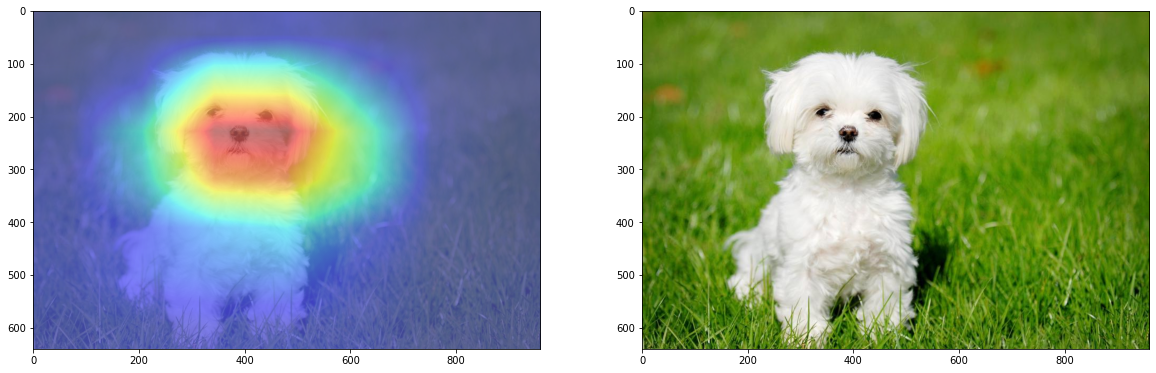

In [20]:
image = cv2.imread("dog.jpg")
im_orig = image.copy()
im_orig = cv2.cvtColor(im_orig, cv2.COLOR_BGR2RGB)  # imagem utilizada para plotar com matplotlib (Usa RGB em vez de BGR)
image = preprocess_input(image)  # função fornecida pelo keras que pre processa a imagem de acordo com a rede escolhida.

image = cv2.resize(image, (224, 224))  # o preprocess_input apenas faz as transforções e não altera a resolução original
image = image[np.newaxis, :]
feature_map, prob = prepared_model.predict(image)

best_prob = prob.argmax()
print(best_prob, prob.max())
# acessamos os pesos do neurônio em especifico e utilizaremos eles para ponderar as respostas de cada feature map
w_prob = weights[:, best_prob]

feature_map = feature_map[0]  # como é apenas uma unica amostra não precisamos da dimensão zero
for k in range(wProb.shape[0]):
    feature_map[..., k] = feature_map[..., k] * wProb[k] 
fm = feature_map.sum(axis=2)
fm -= fm.min()  # colocamos como referencia o zero, ou seja nosso menor valor será o 0
fm /= fm.max()  # normalizamos os valores entre 0 e 1
fm *= 255.0  # colocamos de 0 a 255 (padrão de uma imagem)
fm = np.uint8(fm)  # alteramos o tipo para uint8

#  O mapa de caracteristca que utilizamos tem dimensão 7x7, pois passou por inumeras convoluções e maxpoolings que reduziu o 
# tamanho original. Utilizando o resize do opencv podemos deixar no tamanho original, apesar de não conseguirmos tirar o efeito
# blur
fm = cv2.resize(fm, (im_orig.shape[1], im_orig.shape[0]))

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax.imshow(im_orig, alpha=0.5)
ax.imshow(fm, cmap='jet', alpha=0.5)
ax2.imshow(im_orig)
